In [1]:
# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import pymongo as pm
import metaknowledge as mk
import os
import pyprind
import pickle
import spacy
import numpy as np
import time

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from scipy.spatial.distance import cosine
from scipy.stats import entropy
from numpy.linalg import norm

import seaborn as sns
%matplotlib inline

This notebook generates an LDA topic model from the notebook, and also calculates a variety of summary statisticis.

In [2]:
client = pm.MongoClient()
local = client.local
local.list_collection_names()
fletcher = local.get_collection('fletcher')

In [3]:
progbar = pyprind.ProgBar(fletcher.count())

data = {}

for a in fletcher.find():
    try:
        if a['AB']:
            data[a['_id']]=a['AB']
    except:
        pass
    progbar.update()

/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


CountVectorizer creates a vectorized dictionary to feed into the Gensim LDA topic model.  An an input, CountVectorizer likes a list of strings, so the lemmatizer function defined below creates cleaned abstracts with the words all set to lowercase and lemmatized as a clean input.

In [4]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

import string

stop = stopwords.words('english')

table = str.maketrans({key: None for key in string.punctuation})
 
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def lemmatization(abstract):
    words = abstract.split(' ')
    out = []
    for word in words:
        word = word.lower()
        word = word.translate(table)
        if word not in stop:
            lem = lemmatiser.lemmatize(word)
            if lem != '':
                out.append(lem)
        
    return (' '.join(out))

In [5]:
abstracts = []
for x in data:
    abstracts.append(data[x])

progbar = pyprind.ProgBar(len(abstracts))
    
abs_lemma =[]

for ab in abstracts:
    abs_lemma.append(lemmatization(ab))
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:21


These cells do the heavy lifting for the NLP, and take about 45 minutes to run.  As such I recommend using the first cell below to load the items from disk.

Parameter search suggested using trigrams, a mimumum document frequency frequency of 3, maximum document freqeuncy of 0.1, and a topic minimum probability of 0.003 gives acceptable results.

In [7]:
#loading cell. Skip if running for first time.

model = models.LdaModel.load('models/lda40x3trim0-1.model', mmap='r')

2018-11-20 11:13:19,346 : INFO : loading LdaModel object from models/lda40x3trim0-1.model
2018-11-20 11:13:19,366 : INFO : loading expElogbeta from models/lda40x3trim0-1.model.expElogbeta.npy with mmap=r
2018-11-20 11:13:19,368 : INFO : setting ignored attribute dispatcher to None
2018-11-20 11:13:19,371 : INFO : setting ignored attribute id2word to None
2018-11-20 11:13:19,372 : INFO : setting ignored attribute state to None
2018-11-20 11:13:19,373 : INFO : loaded models/lda40x3trim0-1.model
2018-11-20 11:13:19,373 : INFO : loading LdaState object from models/lda40x3trim0-1.model.state
2018-11-20 11:13:19,388 : INFO : loading sstats from models/lda40x3trim0-1.model.state.sstats.npy with mmap=r
2018-11-20 11:13:19,417 : INFO : loaded models/lda40x3trim0-1.model.state


In [4]:
count_vectorizer = pickle.load(open("count_vectorizer.pickle","rb"))
counts = pickle.load(open("counts.pickle","rb"))
corpus = pickle.load(open("corpus.pickle","rb"))
id2word = pickle.load(open("id2word.pickle","rb"))

2018-11-20 09:42:21,183 : INFO : loading LdaModel object from models/lda40x3trim0-1.model


FileNotFoundError: [Errno 2] No such file or directory: 'models/lda40x3trim0-1.model'

In [8]:
count_vectorizer = CountVectorizer(ngram_range=(1,3), lowercase=True, 
                                   stop_words='english', min_df=3, max_df=0.1)

counts = count_vectorizer.fit_transform(abs_lemma).transpose()

corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

pickle_out = open("count_vectorizer.pickle","wb")
pickle.dump(count_vectorizer, pickle_out)
pickle_out.close()

pickle_out = open("counts.pickle","wb")
pickle.dump(counts, pickle_out)
pickle_out.close()

pickle_out = open("corpus.pickle","wb")
pickle.dump(corpus, pickle_out)
pickle_out.close()

pickle_out = open("id2word.pickle","wb")
pickle.dump(id2word, pickle_out)
pickle_out.close()

In [2]:
model = models.LdaModel(corpus=corpus, num_topics=40, minimum_probability=0.003, 
                        id2word=id2word, passes=10, chunksize=10000, update_every=10)

model.save('models/lda40x3trim0-1.model')

NameError: name 'corpus' is not defined

In [9]:
topics = model.print_topics(num_topics=40, num_words=5)[:]

2018-11-20 11:15:57,584 : INFO : topic #0 (0.025): 0.003*"cd8" + 0.002*"cd8 cell" + 0.002*"infection" + 0.002*"cd4" + 0.002*"hiv"
2018-11-20 11:15:57,590 : INFO : topic #1 (0.025): 0.005*"virus" + 0.005*"rna" + 0.003*"specie" + 0.003*"host" + 0.003*"evolution"
2018-11-20 11:15:57,599 : INFO : topic #2 (0.025): 0.009*"material" + 0.008*"reaction" + 0.006*"synthesis" + 0.005*"property" + 0.005*"polymer"
2018-11-20 11:15:57,607 : INFO : topic #3 (0.025): 0.006*"galaxy" + 0.005*"star" + 0.005*"mass" + 0.003*"black" + 0.003*"hole"
2018-11-20 11:15:57,620 : INFO : topic #4 (0.025): 0.003*"asthma" + 0.002*"variant" + 0.002*"health" + 0.001*"major" + 0.001*"individual"
2018-11-20 11:15:57,625 : INFO : topic #5 (0.025): 0.006*"mg" + 0.005*"month" + 0.005*"phase" + 0.004*"week" + 0.004*"dose"
2018-11-20 11:15:57,633 : INFO : topic #6 (0.025): 0.005*"month" + 0.004*"placebo" + 0.004*"score" + 0.004*"woman" + 0.003*"day"
2018-11-20 11:15:57,642 : INFO : topic #7 (0.025): 0.010*"stem" + 0.009*"stem

In [39]:
model.log_perplexity(corpus)

2018-11-14 13:23:44,206 : INFO : -10.966 per-word bound, 2000.7 perplexity estimate based on a held-out corpus of 71161 documents with 11775812 words


-10.966267438786248

In [10]:
#A snippet of code to generate better formatted top words in each topic for use in presentations. 

a = topics[0:7]
b = [x[1] for x in a]

for i in range(len(a)):
    c = b[i].replace('+', '*')
    d = c.split('*')[1::2]
    print([x.strip().replace('"', '') for x in d])

['cd8', 'cd8 cell', 'infection', 'cd4', 'hiv']
['virus', 'rna', 'specie', 'host', 'evolution']
['material', 'reaction', 'synthesis', 'property', 'polymer']
['galaxy', 'star', 'mass', 'black', 'hole']
['asthma', 'variant', 'health', 'major', 'individual']
['mg', 'month', 'phase', 'week', 'dose']
['month', 'placebo', 'score', 'woman', 'day']


In [16]:
lda_corpus = model[corpus]

lda_docs = [doc for doc in lda_corpus]

In [26]:
def Topic_Rao_Stirling(lda_doc, cos_sims):
    SDI = 0
    for itema in lda_doc:
        for itemb in lda_doc:
            distance = 1-cos_sims[itema[0], itemb[0]]
            SDI += distance*itema[1]*itemb[1]
    return SDI

For several of the next calculations, we need the topics as vectorized probability distributions. This function does that.

In [11]:
vectors = []

topn=500000

v = len(id2word)

progbar = pyprind.ProgBar(len(topics))

for k in range(len(topics)):
    vec = np.zeros(v)
    a = model.get_topic_terms(k, topn=v)
    for item in a:
        vec[item[0]]=item[1]
    vectors.append(vec)
    progbar.update()
    
topic_vectors = vectors

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


We can visualize the cosine distance between all pairs of topics as a heatmap to see they are generally distinct, with a mean distance of 0.64.

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


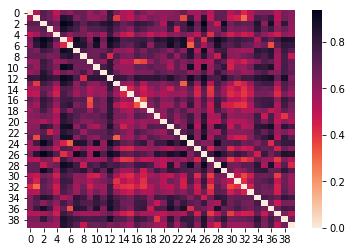

In [13]:
cos_dists = np.zeros(shape=(len(topics), len(topics)))

progbar= pyprind.ProgBar(len(topics)**2)

for k in range(len(topics)):
    a = topic_vectors[k]
    for m in range(len(topics)):
        b=topic_vectors[m]
        cos_dists[k, m] = cosine(a, b)
        progbar.update()

sns.heatmap(cos_dists, cmap='rocket_r')

In [14]:
np.mean(cos_dists)

0.6421065894282723

One possible measure of interdisciplinarity is the topic [Rao-Stirling score](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2373389/) which is calculated by using the standard Rao-Stirling measure with the distance provided by the cosine distance calculated above.

In [17]:
def Topic_Rao_Stirling(lda_doc, cos_dists):
    residue = 1 - sum([x[1] for x in lda_doc])
    lda_doc.append(('residue', residue))
    SDI = 0
    for itema in lda_doc:
        for itemb in lda_doc:
            try:
                distance = cos_dists[itema[0], itemb[0]]
            except:
                distance = 1
            SDI += distance*itema[1]*itemb[1]
    return SDI

topic_SDI = dict()
keys = list(data.keys())

progbar = pyprind.ProgBar(len(data))

for i in range(len(lda_docs)):
    key = keys[i]
    value = Topic_Rao_Stirling(lda_docs[i], cos_dists)
    topic_SDI[key] = value
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


In [165]:
progbar = pyprind.ProgBar(len(topic_SDI))

for item in topic_SDI:
    fletcher.update_one({'_id':item}, {"$set":{"LDA40x3Trim01":topic_SDI[item]}})
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34


An alternative measure of the distance between probability distributions is the [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence). I wound up using this to calculate the Novelty score.

In [18]:
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:52


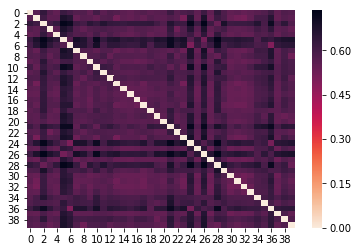

In [20]:
progbar= pyprind.ProgBar(len(vectors)**2)

jsd_sims =  np.zeros(shape=(len(vectors), len(vectors)))
for k in range(len(topics)):
    a = vectors[k]
    for m in range(len(topics)):
        b = vectors[m]
        jsd_sims[k, m] = np.sqrt(JSD(a,b))
        progbar.update()


sns.heatmap(jsd_sims, cmap='rocket_r')

This calculautes a Rao-Stirling diversity index using the Jensen-Shannon difference between topics.

In [21]:
def Topic_JSD(lda_doc, jsd_sims):
    residue = 1 - sum([x[1] for x in lda_doc])
    if residue != 0:
        lda_doc.append(('residue', residue))
    JSD = 0
    for itema in lda_doc:
        for itemb in lda_doc:
            try:
                distance = jsd_sims[itema[0], itemb[0]]
            except:
                distance = 1
            JSD += distance*itema[1]*itemb[1]
    return JSD

Topic_JSD(lda_docs[0], jsd_sims)

0.4952375217168997

In [174]:
topic_JSD = dict()
keys = list(data.keys())

progbar = pyprind.ProgBar(len(data))

for i in range(len(lda_docs)):
    key = keys[i]
    value = Topic_JSD(lda_docs[i], jsd_sims)
    topic_JSD[key] = value
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


In [175]:
progbar = pyprind.ProgBar(len(topic_JSD))

for item in topic_JSD:
    fletcher.update_one({'_id':item}, {"$set":{"JSD40x3Trim01":topic_JSD[item]}})
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31


These functions allow us to calculate the Jensen-Shannon divergence between an abstract in our corpus and the topics which it is composed of according to the LDA model.  This function takes about 0.06 seconds to run, which means an hour to calculate for the whole dataset.  

I'm not sure that there are meaningful improvements to be found. Most of the time is spent in the JSD function, which is already vectorized.

In [25]:
def ab2vec(corp, v):
    vec = np.zeros(v)
    for item in corp:
        vec[item[0]]= item[1]
    return vec

a = ab2vec(corpus[0],v)

def topic_combiner(doc, topic_vectors):
    vec = np.zeros(len(topic_vectors[0]))
    for item in doc:
        try:
            vec += topic_vectors[item[0]]*item[1]
        except:
            pass
    return vec

array([1.67906367e-05, 6.16086171e-07, 5.24381735e-06, ...,
       2.50334224e-06, 2.61906699e-06, 1.39935081e-07])

In [34]:
t0 = time.time()
a = ab2vec(corpus[0],v)
b = topic_combiner(lda_docs[0], topic_vectors)
print('Novelty %.4f' % JSD(a, b))
t1 = time.time()
print('time: %.4f' % (t1-t0))

Novelty 0.6865
time: 0.0102


In [189]:
novelty = dict()
keys = list(data.keys())

progbar = pyprind.ProgBar(len(data), title='tJSD')

for i in range(len(lda_docs)):
    key = keys[i]
    a = ab2vec(corpus[i],v)
    b = topic_combiner(lda_docs[i], topic_vectors)
    value = JSD(a,b)
    novelty[key] = value
    progbar.update()

tJSD
0% [#############                 ] 100% | ETA: 00:36:22/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 01:04:04


And we update each record with the Novelty score.

In [190]:
progbar = pyprind.ProgBar(len(data))

for item in tJSD:
    fletcher.update_one({'_id':item}, {"$set":{"Novelty":tJSD[item]}})
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32


An ugly series of loops to update the database with topics.  It works, it's fast enough, and the project was due.

In [194]:
lda_docs2 = []

progbar = pyprind.ProgBar(len(lda_docs))

for a in lda_docs:
    b = []
    for item in a:
        if item[0] != 'residue':
            b.append(item)
    lda_docs2.append(b)
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [198]:
lda_docs3 = dict()
keys = list(data.keys())

progbar = pyprind.ProgBar(len(data), title='lda_docs3')

for i in range(len(lda_docs)):
    key = keys[i]
    value = lda_docs2[i]
    lda_docs3[key] = value
    progbar.update()

lda_docs3
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [206]:
progbar = pyprind.ProgBar(len(data))

for item in lda_docs3:
    fletcher.update_one({'_id':item}, {"$set":{"lda_doc":str(lda_docs3[item])}})
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:57
